### Introduction

The goal of the following algorithm is to identify breast cancer, using only a small fraction of the available data (N=1148 for training, N=163 for testing and N=382 for the validation set) from the BreakHis dataset.

This is probably too little data to train a ConvNet from scrath, so we will use a technique called Transfer Learning, which consists in adding a classifier on top of a pretrained ConvNet. Here, we will use the Xception ConvNet which is pretained on a the ImageNet dataset (A bank of 14 million labelled images)

#### Results

After fine-tuning of our model, we reached a 91.36 % accuracy on unseen data

#### Imports

In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import time
import cv2
import os

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers

In [16]:
path_images = '/Users/Casey/Desktop/3eyeDiagnosis/BreakHis'

extensions = ['train', 'test']
label_extensions = ['benign', 'malignant']

In [17]:
def encode_label(label):
    if label == 'benign':
        return(0)
    elif label == 'malignant':
        return(1)
    else:
        raise Exception("Can't encode the value", label)

In [18]:
def encode_label(label):
    if label == 'benign':
        return(0)
    elif label == 'malignant':
        return(1)
    else:
        raise Exception("CACACA")

def build_data(extensions, label_extensions, path_images):
    
    images_train, images_test, labels_train, labels_test = [], [], [], []
    
    for extension in extensions:
        for label in label_extensions:
            path=os.path.join(path_images,extension,label)

            for img in os.listdir(path):
                img_array = cv2.imread(os.path.join(path,img))
                encoded_label = encode_label(label)

                if extension == 'train' :
                    images_train.append(img_array)
                    labels_train.append(encoded_label)
                
                elif extension == 'test':
                    images_test.append(img_array)
                    labels_test.append(encoded_label)
                
                else:
                    print("Passed")
                    pass
        
    return(images_train, images_test, labels_train, labels_test)

In [19]:
images_train, images_test, labels_train, labels_test = build_data(extensions, label_extensions, path_images)

In [20]:
def bar_labels(labels,title):
    
    if len(np.unique(labels)) == 2:
        values = [(len(labels) - np.sum(labels))/len(labels), np.sum(labels)/len(labels)]
        plt.bar(np.unique(labels),values, label='Unique values frequencies', color='pink')
        plt.legend()
        plt.title(title)
        plt.show()
        
        print(values)
    
    else:
        raise Exception("np.unique(labels) has length != 2")

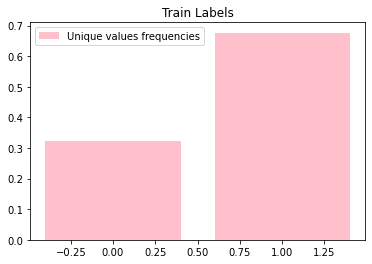

[0.3231707317073171, 0.676829268292683]


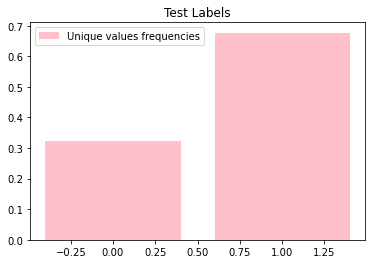

[0.3229357798165138, 0.6770642201834862]


In [21]:
bar_labels(labels_train,'Train Labels')

bar_labels(labels_test,'Test Labels')

The proportion of malignant labels might be a bit too high. Problem is we have such a tiny amount of training/testing examples that we can't afford to drop a significant part of them

#### Preprocessing

In [22]:
from sklearn.utils import shuffle as sk_shuffle

def resize(new_size, *args):
    return_list = []
    
    for arg in args:
        new_arg = []
        for k in range(len(arg)):
            resized_img = cv2.resize(arg[k], (new_size, new_size))
            new_arg.append(resized_img)
        return_list.append(new_arg)
    return(return_list)

def standardize(*args):
    return_list = []
    
    for arg in args:
        standardized_arg = []
        
        for img in arg:
            img = img - np.mean(img)
            img = img / np.std(img)
            standardized_arg.append(img)
        return_list.append(standardized_arg)
    return(return_list)

def shuffle(X,y):
    X_shuffle, y_shuffle = sk_shuffle(X, y, random_state=0)
    return(X_shuffle, y_shuffle)

# In this particular case, we have to split the "test" set into two parts : an actual testing set and a validation set
def split_test_val(X, y, test_ratio):
    length = int(test_ratio * len(X))
    new_images_test, new_labels_test = X[0:length] , y[0:length]
    new_images_val, new_labels_val = X[length:] , y[length:]
    
    return(new_images_test, new_images_val, new_labels_test, new_labels_val)

In [23]:
# resizing
images_train, images_test = resize(images_train[0].shape[0], images_train, images_test)

# standardization
images_train_sd, images_test_sd = standardize(images_train, images_test)

In [24]:
# shuffling the training and testing images/labels
X_train, y_train = shuffle(images_train_sd, labels_train)

X_test, y_test = shuffle(images_test_sd, labels_test)

In [25]:
# Splitting, creating the testing and validation sets

test_ratio = 0.3

X_test, X_val, y_test, y_val = split_test_val(X_test, y_test, test_ratio)

In [26]:
# Conversion to array

def convert_to_array(*args):
    return_list = []
    
    for arg in args:
        return_list.append(np.array(arg))
    return(return_list)

In [27]:
X_train, y_train, X_test, y_test, X_val, y_val = convert_to_array(X_train, y_train, X_test,
                                                                 y_test, X_val, y_val)

At this point, the data is preprocessed, meaning that we separated it in three different set (a training set to train the network, a testing set to monitor the accuracy of the network during the training phases, and a validation set to validate our model

$\textit{Remark :}$ The BreakHis dataset contains images of lymph node section scans, with four different images for the same patient, with a different zoom (x40, x100, x200, x400)
There is no change that our three datasets are interacting, as we only kept the x400 zoomed scans. By doing so, we cancel the risk that two pictures coming from the same appear in two different sets, which could have been biasing our accuracy

#### Model, Transfer Learning

In [25]:
# Importing Xception

input_shape = X_test[0].shape

Xception = tf.keras.applications.Xception(include_top=False, weights="imagenet",
    input_tensor=None, input_shape=input_shape, pooling=None, 
    classes=1000, classifier_activation="softmax")

Xception.trainable = False

In [26]:
# Defining a model, adding three layers on top of the pretrained "base model" ConvNet

def transfer_model(base_model):
    model = Sequential()
    
    model.add(base_model)
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(Dense(512, kernel_regularizer=regularizers.l1(l1=0.001), activation= 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, kernel_regularizer=regularizers.l1(l1=0.001), activation= 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, kernel_regularizer=regularizers.l1(l1=0.001), activation= 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation= 'sigmoid'))

    return(model)

In [27]:
model = transfer_model(Xception)

In [28]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'acc')

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 15, 15, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [30]:
early_stopping = [tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]

number_epochs = 10
history = model.fit(X_train, y_train, batch_size = 16, verbose = 1,
                      epochs = number_epochs, validation_data=(X_test, y_test), callbacks = early_stopping)

Epoch 1/10
72/72 [==============================] - 766s 10s/step - loss: 16.7962 - acc: 0.7091 - val_loss: 2.1886 - val_acc: 0.8160
Epoch 2/10
72/72 [==============================] - 709s 10s/step - loss: 1.7784 - acc: 0.8182 - val_loss: 1.2698 - val_acc: 0.8098
Epoch 3/10
72/72 [==============================] - 695s 10s/step - loss: 1.1990 - acc: 0.8204 - val_loss: 1.0096 - val_acc: 0.8405
Epoch 4/10
72/72 [==============================] - 700s 10s/step - loss: 0.9784 - acc: 0.8544 - val_loss: 0.9434 - val_acc: 0.8344
Epoch 5/10
72/72 [==============================] - 693s 10s/step - loss: 0.8894 - acc: 0.8638 - val_loss: 0.8861 - val_acc: 0.8405
Epoch 6/10
72/72 [==============================] - 702s 10s/step - loss: 0.7849 - acc: 0.8899 - val_loss: 0.9288 - val_acc: 0.7730
Epoch 7/10
72/72 [==============================] - 694s 10s/step - loss: 0.8176 - acc: 0.8536 - val_loss: 0.7836 - val_acc: 0.8466
Epoch 8/10
72/72 [==============================] - 689s 10s/step - loss: 0

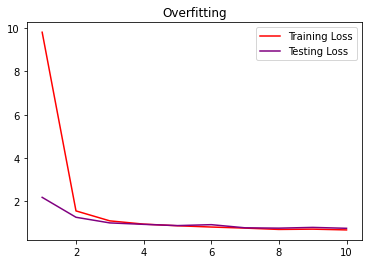

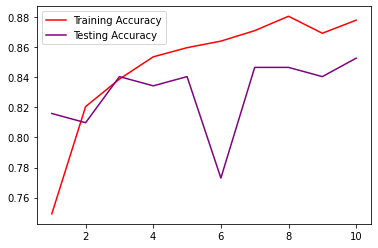

In [34]:
plot_history(history, 10)

In [31]:
model.evaluate(X_val, y_val)

12/12 [==============================] - 225s 18s/step - loss: 0.6363 - acc: 0.8901


[0.6362903714179993, 0.8900523781776428]

#### Fine-tuning the k-last Xception layers

In the following lines, we perform the fine-tuning of the model, meaning that we will unfreeze a few of the last layers from the ConvNet, to train them and the classifier with a very low learning rate on the optimizer, to slightly adjust the network to our data even more. As before, we will use the Keras Callback Early Stopping to monitor the accuracy on the testing set and avoiding overfitting by restoring weights to the optimal fine-tuned model

In [7]:
def set_trainable(model_input):
    model_input.trainable = True
    
    for layer in model_input.layers[1:]:
        layer.trainable = True

    model_input.layers[0].trainable = False
    
    model_input.layers[0].trainable = True

    for layer in model_input.layers[0].layers:
        if layer not in model_input.layers[0].layers[-3:]:
            layer.trainable = False
    
    return(model_input)

#### Saving the model before fine-tuning to compare accuracies

In [ ]:
save_path = '/Users/Casey/Desktop/3eyeDiagnosis/saved_models'

def save_model(model_input, path):
    model_input.save(path)

save_model(model,save_path)

In [1]:
save_path = '/Users/Casey/Desktop/3eyeDiagnosis/saved_models'

def load_model(path):
    loaded_model = keras.models.load_model(path)
    return(loaded_model)

In [9]:
# Reloading the model to perform the fine-tuning

reloaded_model = load_model(save_path)

In [10]:
# model_ft will be our final fine-tuned model

model_ft = set_trainable(reloaded_model)

In [12]:
# Compiling, low learning rate
optimizer_ft = keras.optimizers.Adam(1e-5)

model_ft.compile(optimizer = optimizer_ft, loss = 'binary_crossentropy', metrics = 'acc')

In [13]:
model_ft.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 15, 15, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

#### Training, Fine-tuning

In [28]:
number_epochs_ft = 10
early_stopping = [tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]

history_ft = model_ft.fit(X_train, y_train, batch_size = 16, verbose = 1,
                      epochs = number_epochs_ft, validation_data=(X_test, y_test), callbacks = early_stopping)

Epoch 1/10
72/72 [==============================] - 820s 11s/step - loss: 0.6017 - acc: 0.8745 - val_loss: 0.6006 - val_acc: 0.8466
Epoch 2/10
72/72 [==============================] - 782s 11s/step - loss: 0.5013 - acc: 0.9140 - val_loss: 0.5877 - val_acc: 0.8466
Epoch 3/10
72/72 [==============================] - 760s 11s/step - loss: 0.5373 - acc: 0.8862 - val_loss: 0.5799 - val_acc: 0.8466
Epoch 4/10
72/72 [==============================] - 788s 11s/step - loss: 0.4921 - acc: 0.9084 - val_loss: 0.5703 - val_acc: 0.8528
Epoch 5/10
72/72 [==============================] - 750s 10s/step - loss: 0.5003 - acc: 0.9060 - val_loss: 0.5660 - val_acc: 0.8589
Epoch 6/10
72/72 [==============================] - 757s 11s/step - loss: 0.4880 - acc: 0.9127 - val_loss: 0.5644 - val_acc: 0.8589
Epoch 7/10
72/72 [==============================] - 754s 10s/step - loss: 0.5039 - acc: 0.8982 - val_loss: 0.5569 - val_acc: 0.8650
Epoch 8/10
72/72 [==============================] - 753s 10s/step - loss: 0.

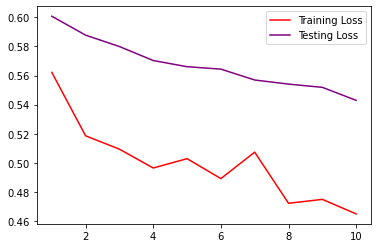

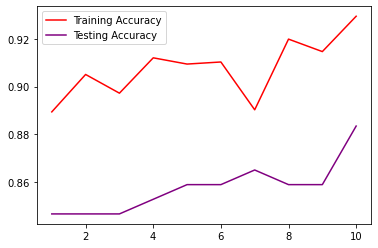

In [39]:
plot_history(history_ft, number_epochs_ft)

#### Accuracy comparaison

In [35]:
# After fine-tuning

model_ft.evaluate(X_val, y_val)

12/12 [==============================] - 236s 19s/step - loss: 0.4679 - acc: 0.9136


[0.4678932726383209, 0.9136125445365906]

The accuracy of the model before fine-tuning the last ConvNet layers was exactly 89 %

With the fine-tuned model, we have a nice improvement of 2.36 % on unseen data, with a 91.36 % accuracy

#### Type 0 and type 1 risks

We call type 0 risk the risk that our final model predicts "malignant" when the actual label is "benign", and type 1 risk, the risk that it classifies "benign" when the actual label is "malignant"

In [58]:
def risk_type(model, X_val, y_val):
    prediction = model_ft.predict(X_val)
    
    nb_mistakes_actual_benign = 0
    nb_mistakes_actual_cancer = 0

    for k in range(len(prediction)):
        if prediction[k] < .5 and y_val[k] == 1:
            nb_mistakes_actual_cancer += 1
        elif prediction[k] > .5 and y_val[k] == 0:
            nb_mistakes_actual_benign +=1
        else:
            pass
        
    type0risk = nb_mistakes_actual_benign / np.shape(X_val)[0]
    type1risk = nb_mistakes_actual_cancer / np.shape(X_val)[0]
    
    return(type0risk, type1risk)

In [60]:
risks = risk_type(model_ft, X_val, y_val)

In [68]:
print("Type 0 risk : ", np.around(100*risks[0], 2),"%")

print("Type 1 risk : ", np.around(100*risks[1], 2), "%")

Type 0 risk :  6.02 %
Type 1 risk :  2.62 %


One reason for such a difference in these two risks is probably that our original dataset contains twice as much malignant tumors that benign ones

#### Conclusion

We performed a transfer learning technique from the Xception ConvNet to our model, that we fine-tuned to get a final accuracy of 91.36% on the prediction of wether or not a sample a breast tumor tissue extracted from a patient contains cancer cells.

To further improve the accuracy of our model, an interesting thing to do would have been to select an optimal set of hyperparameters (optimizer's learning rate, number of epochs, number of Dense layers in the network etc...)
This would have been very time-consuming on a MacBook Air, as a single round of training/fine-tuning took use a little less than five hours